<a href="https://colab.research.google.com/github/Norod/my-colab-experiments/blob/master/ruDALLE_muppets_norod78.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Muppet image generator, based on ruDALL-E fined tuned by [Doron Adler](https://linktr.ee/Norod78) The fined-tuned model is available on [Hugging Face](https://huggingface.co/Norod78/ml-generated-muppets-rudalle/tree/main). 

In [5]:
!pip install --upgrade rudalle > /dev/null

In [6]:
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)
device = device.type

CPU: 2
RAM GB: 12.7
PyTorch version: 1.10.0+cu111
CUDA version: 11.1
cuDNN version: 8005
device: cuda


In [7]:
from datetime import datetime
from rudalle.pipelines import generate_images, show, super_resolution
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_realesrgan
from rudalle.utils import seed_everything
from huggingface_hub import hf_hub_url, cached_download

In [8]:

use_fp16 = False
if device == 'cuda':
    use_fp16 = True
dalle = get_rudalle_model('Malevich', pretrained=False, fp16=use_fp16, device=device)
#dalle = get_rudalle_model('Emojich', pretrained=False, fp16=use_fp16, device=device)

model_filename = "pytorch_model.bin"
config_file_url = hf_hub_url(repo_id="Norod78/ml-generated-muppets-rudalle", filename=model_filename)
cached_download(config_file_url, cache_dir='/content', force_filename=model_filename)

dalle.load_state_dict(torch.load(model_filename, map_location=torch.device(device))) 
print(f'Loaded from {model_filename}')
tokenizer = get_tokenizer()
vae = get_vae(dwt=True).to(device)

Loaded from pytorch_model.bin
tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready


In [9]:
# pipeline utils:
realesrgan = get_realesrgan('x2', device=device)

Downloading:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

x2 --> ready


## generation by ruDALLE

text: Лягушонок


  0%|          | 0/1024 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/rudalle/dalle/model.py:89: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dtype=torch.long, device=self.device) // self.image_tokens_per_dim


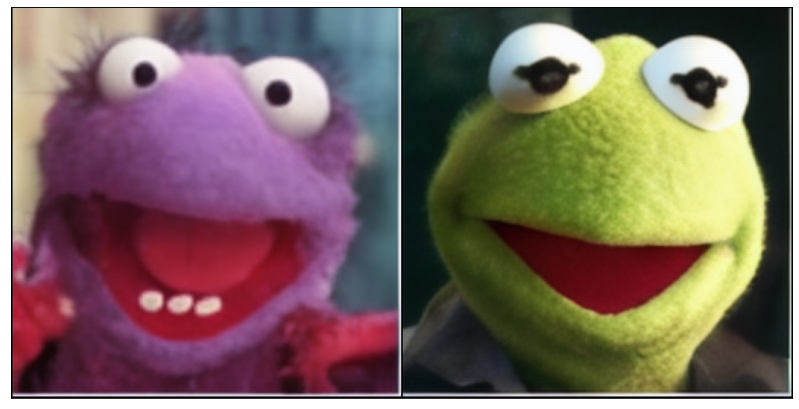

  0%|          | 0/1024 [00:00<?, ?it/s]

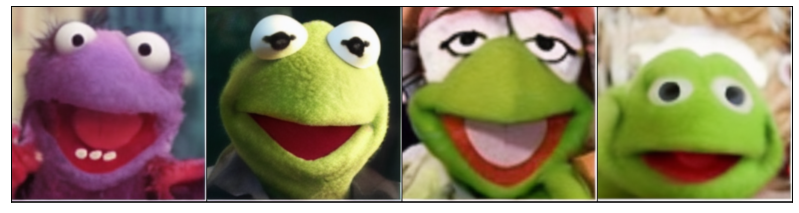

  0%|          | 0/1024 [00:00<?, ?it/s]

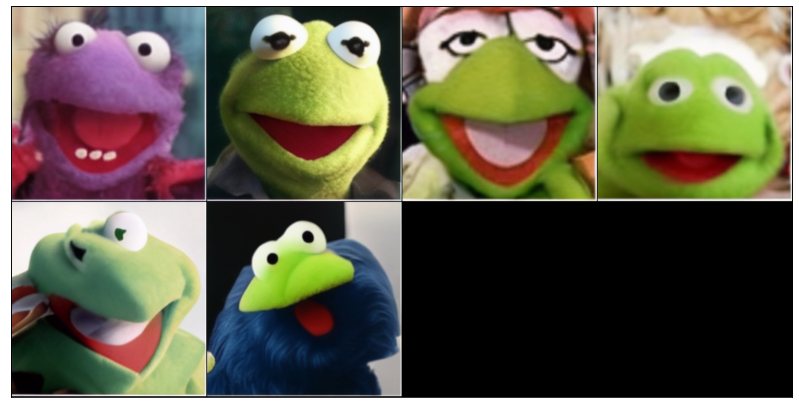

  0%|          | 0/1024 [00:00<?, ?it/s]

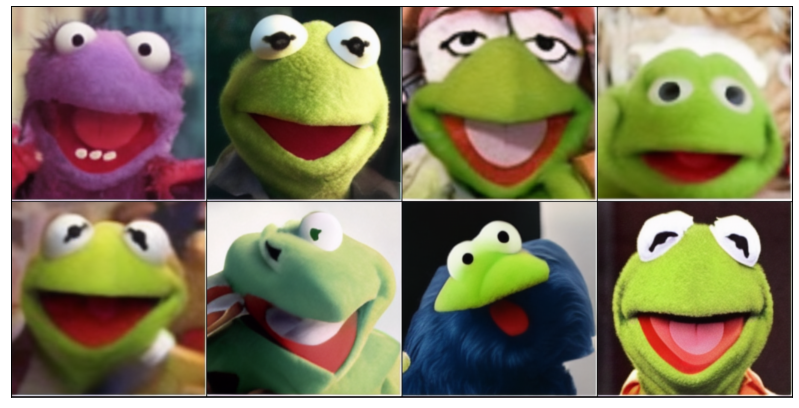

  0%|          | 0/1024 [00:00<?, ?it/s]

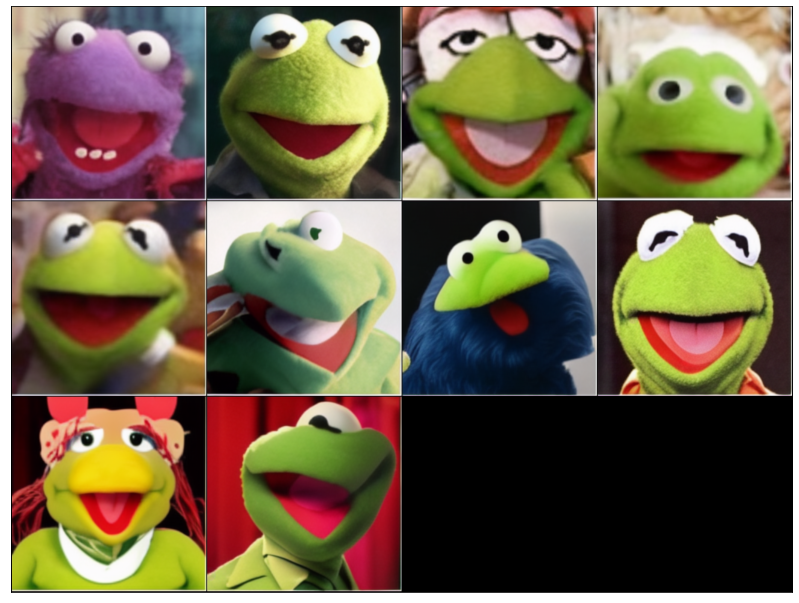

  0%|          | 0/1024 [00:00<?, ?it/s]

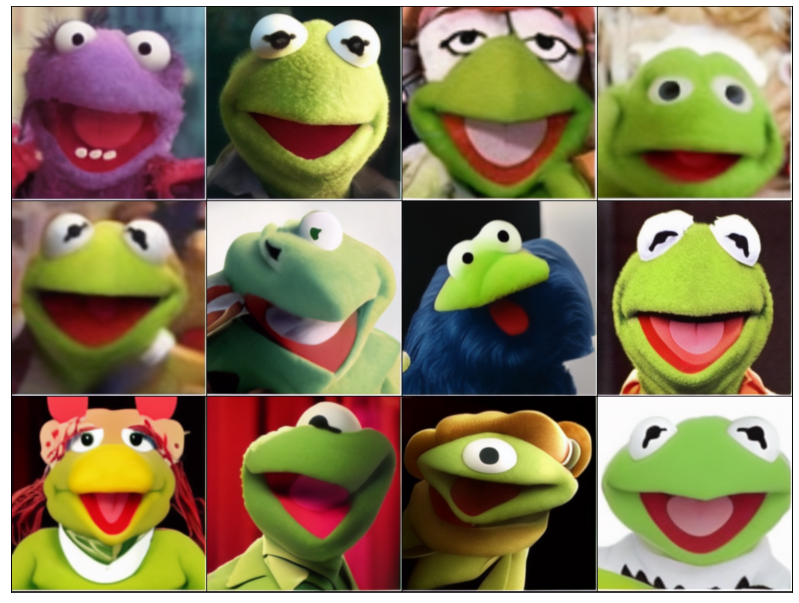

  0%|          | 0/1024 [00:00<?, ?it/s]

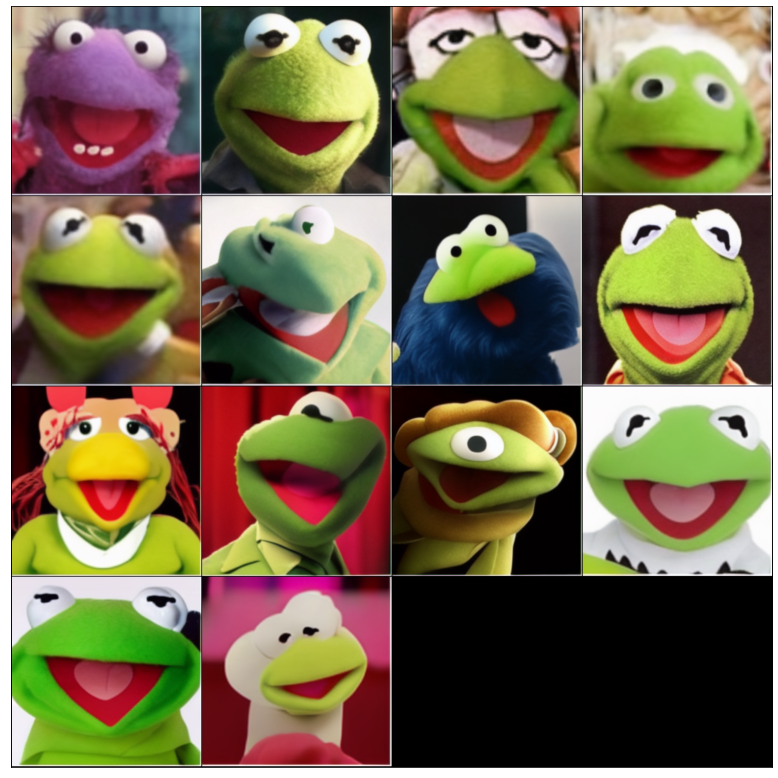

  0%|          | 0/1024 [00:00<?, ?it/s]

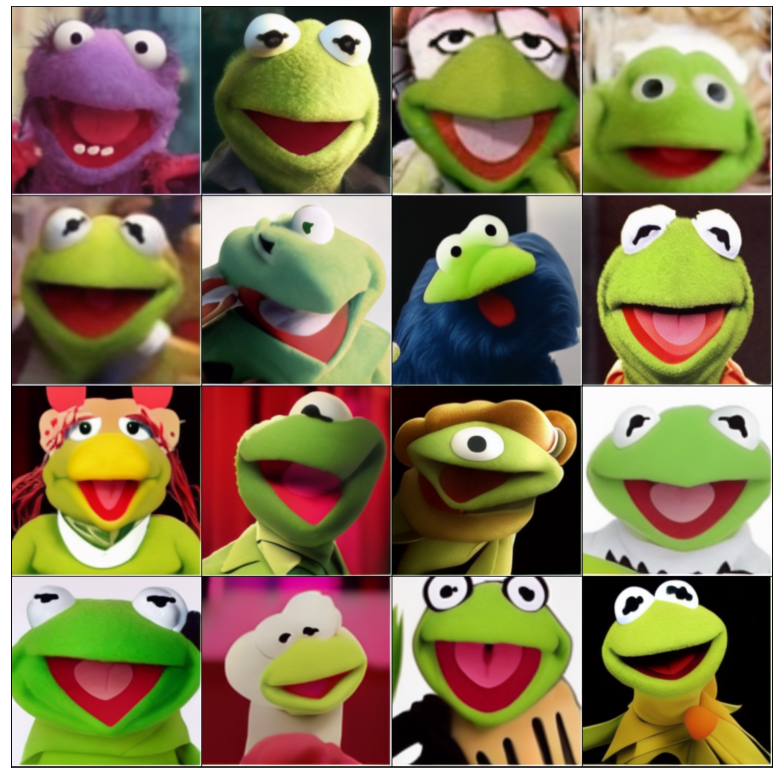

  0%|          | 0/1024 [00:00<?, ?it/s]

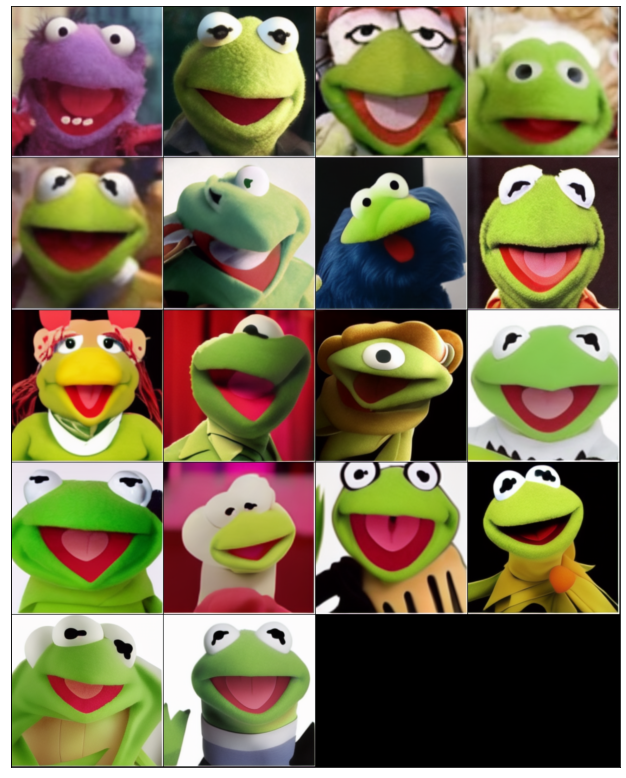

  0%|          | 0/1024 [00:00<?, ?it/s]

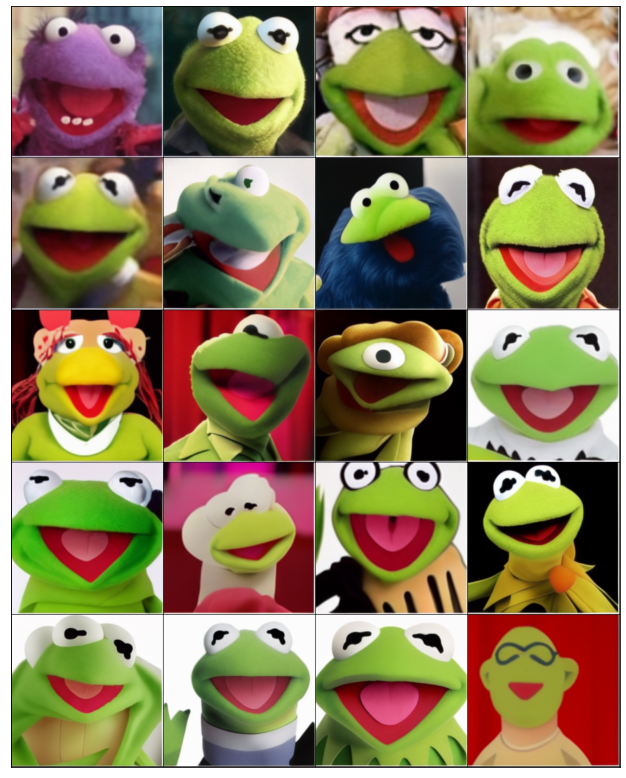

In [11]:
#You might want to edit the inference prompt text below:

#text = 'Маппет'    #muppet
text = 'Лягушонок'  #frog
#text = 'кошка'     #cat
#text = 'Big bird grover' #I did give english names too while fine tuning, but better give stuff translated to Russion
print('text:', text)

#You can try inferencing using the same prompt text, but with different seed values:

seed=42
seed_everything(seed)

pil_images = []
scores = []
if device == 'cuda':
    inference_matrix = [
    (2048, 0.995, 2),
    (1536, 0.99, 2),
    (1024, 0.99, 2),
    (1024, 0.98, 2),
    (512, 0.97, 2),
    (384, 0.96, 2),
    (256, 0.95, 2),
    (128, 0.95, 2), 
    (64,  0.94, 2),
    (32,  0.92, 2)]
else:
    inference_matrix = [(2048, 0.995, 1)]

for top_k, top_p, images_num in inference_matrix:
    _pil_images, _scores = generate_images(text, tokenizer, dalle, vae, top_k=top_k, images_num=images_num, bs=8, top_p=top_p)        
    pil_images += _pil_images
    scores += _scores
    show([pil_image for pil_image, score in sorted(zip(pil_images, scores), key=lambda x: -x[1])] , 4)

## super resolution

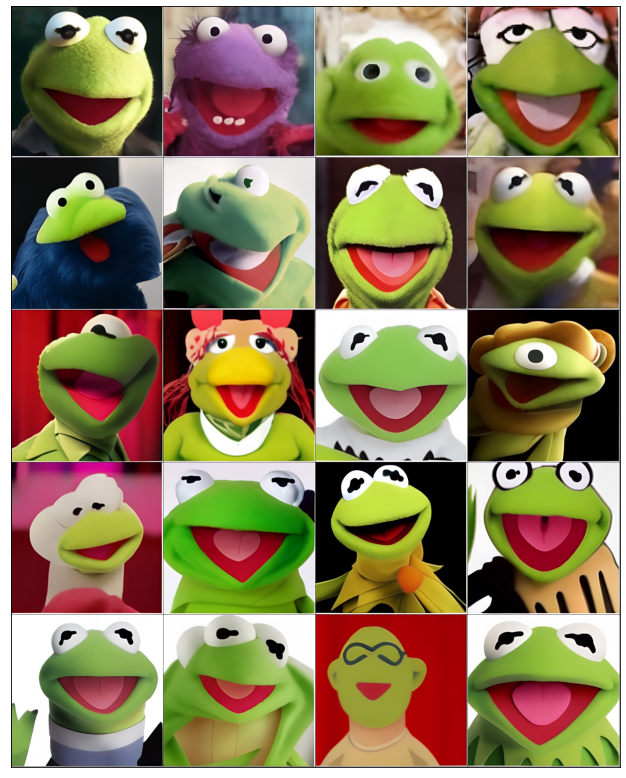

In [12]:
sr_images = super_resolution(pil_images, realesrgan)
show(sr_images, 4)

In [13]:
!mkdir ./output
date = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
for i, (image) in enumerate(sr_images):
    image_file_name = str(f"./output/sr_image_{text}_{seed}_{date}_{i}.jpg")
    image.save(image_file_name)

In [17]:
!echo "You can find your generated images in the folder \"/content/output\":"
!ls /content/output

You can find your generated images in the folder "/content/output":
sr_image_Лягушонок_42_2022_03_15-09_55_50_AM_0.jpg
sr_image_Лягушонок_42_2022_03_15-09_55_50_AM_10.jpg
sr_image_Лягушонок_42_2022_03_15-09_55_50_AM_11.jpg
sr_image_Лягушонок_42_2022_03_15-09_55_50_AM_12.jpg
sr_image_Лягушонок_42_2022_03_15-09_55_50_AM_13.jpg
sr_image_Лягушонок_42_2022_03_15-09_55_50_AM_14.jpg
sr_image_Лягушонок_42_2022_03_15-09_55_50_AM_15.jpg
sr_image_Лягушонок_42_2022_03_15-09_55_50_AM_16.jpg
sr_image_Лягушонок_42_2022_03_15-09_55_50_AM_17.jpg
sr_image_Лягушонок_42_2022_03_15-09_55_50_AM_18.jpg
sr_image_Лягушонок_42_2022_03_15-09_55_50_AM_19.jpg
sr_image_Лягушонок_42_2022_03_15-09_55_50_AM_1.jpg
sr_image_Лягушонок_42_2022_03_15-09_55_50_AM_2.jpg
sr_image_Лягушонок_42_2022_03_15-09_55_50_AM_3.jpg
sr_image_Лягушонок_42_2022_03_15-09_55_50_AM_4.jpg
sr_image_Лягушонок_42_2022_03_15-09_55_50_AM_5.jpg
sr_image_Лягушонок_42_2022_03_15-09_55_50_AM_6.jpg
sr_image_Лягушонок_42_2022_03_15-09_55_50_AM_7.jpg
sr_i